[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/16-Sklearn_Best_Practice_Techniques.ipynb)

# 16. Sklearn - 實用技巧

前幾章的內容裡介紹了建立機器學習模型的基本流程，以及必要的確效驗證步驟。 實務上，建立有效學習模型之前還會有一些不同的問題要解決，例如接下來會提到的交叉驗證及模型超參數選取。 在加入越來越多處理的程式碼後，整個建立模型的步驟也會慢慢變得複雜、難以組織。 這章要介紹 Scikit-learn 所提供的一些實用工具，可以用來簡化這些問題的處理。

+ [**16.1 Pipeline**](#pipeline)
+ [**16.2 交叉驗證 Cross-Validation**](#cross-validation)
+ [**參考資料**](#references)

### Google Colab 環境

在 Google Colab 的環境下，請執行以下程式碼。（詳細說明請參閱 14 章）
```
from google.colab import drive
drive.mount('/content/drive')
```
建立 `dataset` 目錄的連結，記得修改成適合的路徑。
```
!ln -svf 'drive/My Drive/Lecture/Python Machine Learning/dataset' dataset
```

In [1]:
import numpy as np
import pandas as pd

# 載入 House Prices 資料集
train_data = './dataset/HousePrices/train.csv'
X = pd.read_csv(train_data, index_col='Id')

# 目標欄位有漏失標籤的資料列優先丟掉
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
# 把 X, Y 分開
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# 不同特徵群組
category_cols = [col for col in X.columns if X[col].dtype == "object"]
low_card_cols = [col for col in category_cols if X[col].nunique() < 6]
high_card_cols = list(set(category_cols) - set(low_card_cols))
numerical_cols = list(set(X.columns) - set(category_cols))

<a id="pipeline"></a>

## 16.1 Pipeline

`Pipeline` 的設計是用來對整個工作流程簡化。 概念上的簡化處理手法就是
1. 先把個別步驟的方法分別定義好。
2. 將負責處理每個步驟的物件，按照順序放進流程清單，學習模型物件放最後。
3. 對資料集都套用相同的（前）處理流程。

使用 `Pipeline` 的明顯好處是： 比較乾淨的程式碼、流程清楚明確易於維護、有更多的模型確效工具可使用。 Scikit-learn 提供來簡化工作流程的類別有：
+ [**`sklearn.pipeline.Pipeline(steps)`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    - **steps**： 是工作流程的清單，照工作順序放 (*name*, *transform*) 的 tuple 的清單，最後一個一定要是 estimator。
+ [**`sklearn.pipeline.ColumnTransformer(transformers, remainder, n_jobs)`**](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) - 用來針對不同欄位分別套用不同處理，最後會串接各特徵欄位的處理結果。
    - **transformers**： 可以是指定 (*name*, *transformer*, *columns*) 的 tuple 清單，也可以是 *estimator* 或字串 'passthrough'、'drop' 之一。
    - **remainder**： 指定剩下的欄位如何處理，可以是 *estimator* 或字串 'passthrough'、'drop' 之一。
    - **n_jobs**： 指定使用幾個處理器核心平行運算

Note: **`Transformer`** 指的是有實作 `fit()` 及 `transform()` 方法的類別； **`Estimator`** 指的是任何有實作 `transfrom()` 方法的類別。

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# 數值欄位前處理
numerical_transformer1 = SimpleImputer(strategy='constant')
# nominal 類別前處理
nominal_transformer1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
# ordinal 類別前處理
# Note: OrdinalEncoder 沒有提供忽略未知類別的參數
ordinal_transformer1 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('onehot', OrdinalEncoder(categories='auto'))
    ])

### § 使用 `ColumnTransformer` 分別處理不同欄位

數值欄位、ordinal 和 nominal 類別數據的前處理分別定義，然後放在 `ColumnTransformer` 裡並指定對應的處理欄位，但 `OrdinalEncoder` 需要另外特別處理。

In [3]:
from sklearn.compose import ColumnTransformer

# 把針對不同欄位的處理綁在一起
preprocessor1 = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer1, numerical_cols),
        #('ordinal', ordinal_transformer1, high_card_cols),
        ('nominal', nominal_transformer1, low_card_cols)
    ])

### § 使用 Pipeline 學習及驗證

最後我們將前處理與模型綁在一個 Pipeline 上。 與一般的學習模型一樣，最終包含前處理及學習模型的 Pipeline 有 `fit()` 及 `predict()` 方法，訓練及確效驗證就改成使用 Pipeline 的方法。 可以注意到，不需要再分別對 training set 和 validation set 各套一次相同的處理程式碼， Pipeline 會在訓練或預測之前負責自動處理。

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 將前處理及學習模型定義為制式的 pipeline 工作流程
model1 = RandomForestRegressor(n_estimators=100, random_state=0)
pipe1 = Pipeline(steps=[('preprocessor1', preprocessor1), ('model1', model1)])

# 相同的工作流程套用到訓練集的學習，以及驗證集的預測
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
pipe1.fit(X_train, y_train)
predicts1 = pipe1.predict(X_valid)
print('策略 1 MAE:', mean_absolute_error(y_valid, predicts1))

策略 1 MAE: 17779.828047945204


### § 細緻一點的處理手法

由於 `OrdinalEncoder` 沒有提供忽略未知類別的參數，上一個範例的 preprocessor1 裡若加入 ordinal_transformer，將會導致在 validation set 裡沒看過的類別轉碼失敗。 使用 `Pipeline` 遇到這樣的狀況時，就只好自己寫一個相容的前處理類別，或是另外把前處理獨立在 train-test 分割前作。 

In [5]:
# 避免改到原始的資料，複製一份 X
X2 = X.copy()
# ordinal 欄位編碼獨立處理，不放在 pipe 裡
X2[high_card_cols] = X2[high_card_cols].fillna(value='NA') 
ordinal_encoder = OrdinalEncoder(categories='auto')
X2[high_card_cols] = ordinal_encoder.fit_transform(X2[high_card_cols])

In [6]:
# 先前的經驗知道，有 NaN 的數值欄位丟掉效果比較好
num_cols_with_na = [col for col in numerical_cols if X2[col].isna().any()]
num_cols_no_na = list(set(numerical_cols) - set(num_cols_with_na))

In [7]:
# 數值欄位前處理
numerical_transformer2 = SimpleImputer(strategy='constant')
# nominal 類別前處理
nominal_transformer2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [8]:
# 把針對不同欄位的處理綁在一起
preprocessor2 = ColumnTransformer(
    transformers=[
        #('num_with_na', 'drop', num_cols_with_na),
        ('num_no_na', numerical_transformer2, num_cols_no_na),
        ('ordinal', 'passthrough', high_card_cols),
        ('nominal', nominal_transformer2, low_card_cols)
    ])

In [9]:
# 將前處理及學習模型定義為制式的 pipeline 工作流程
model2 = RandomForestRegressor(n_estimators=100, random_state=0)
pipe2 = Pipeline(steps=[('preprocessor2', preprocessor2), ('model2', model2)])

# 相同的工作流程套用到訓練集的學習，以及驗證集的預測
X2_train, X2_valid, y_train, y_valid = train_test_split(X2, y, train_size=0.8, test_size=0.2, random_state=0)
pipe2.fit(X2_train, y_train)
predicts2 = pipe2.predict(X2_valid)
print('策略 2 MAE:', mean_absolute_error(y_valid, predicts2))

策略 2 MAE: 16894.790547945206


<a id="cross-validation"></a>

## 16.2 交叉驗證 Cross-Validation

在之前的確效驗證範例中，我們為了儘可能模擬真實世界的新資料，保留了一小部分（holdout）的子資料集與訓練過程隔離。 範例中使用 `train_test_split()` 的工具函式來幫忙，但其實隱藏了一些還沒被提出來討論的問題：
+ 要保留那一小部分作確效驗證才有代表性？
+ 要保留多大的驗證集？ 還是保留多少的比例？

光是切割就有很多可以討論的細節，但簡單直覺的答案就是： 最好是全部資料都用來訓練和驗證。 這個簡單的概念是可以有折衷方式完成的，把訓練集拆成 k 個小段（k-fold），每次都只保留其中某一段作驗證，其餘的作訓練，全部小段都同樣輪流作一次，然後把 k 次的結果作平均。 這樣就所有的資料都有訓練過也驗證過，這種交叉驗證的手法我們稱為 **k-Fold Cross-Validation**。

![5-Fold Cross-Validation](./image/kfold_cross_validation.png)

上圖（[圖示來源](https://www.kaggle.com/learn/intermediate-machine-learning)）將資料切割為五段，每一段包含所有資料集的其中 20%，這樣我們稱為 5-fold。 因為沒有浪費任何資料，這樣的交叉驗證方式可以更精準的評估學習模型的效能。 缺點是 k 次的交叉驗證要花比較久的時間運算，所以如果是如百萬筆等級的大型資料集，隨機抽樣 1% 都還有個一萬筆，這樣就可以不需要 k-fold。 至於要選擇幾個 k 的 fold，沒有一定的準則，通常是觀察拿來訓練的數量是否足夠大。 一般的選擇會是 train-test 80-20 的比例，若是訓練集非常小的話可以採取 leave-one-out（共 n 筆作 n-fold）的特殊作法。 

所以整體而言，機器學習資料集的使用方式常見如下圖（[圖示來源](https://scikit-learn.org/stable/modules/cross_validation.html)）的分配方式。
全部資料會先分割成 *Training set* 與 *Test set*，只拿 *Training set* 來作訓練及 k-fold 交叉驗證，*Test set* 完全不參與模型的訓練及交叉驗證，只有在最後模型訓練結束後用來預測評估結果。

![k-Fold Cross-Validation with Test](./image/kfold_cross_validation_with_test.png)

Scikit-learn 將交叉驗證的類別放在 `model_selection` 模組中，以下範例會介紹常用的 `KFold` 及 `cross_validate` 的用法。
+ [**`sklearn.model_selection.KFold(n_splits, shuffle)`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
+ [**`sklearn.model_selection.StratifiedKFold(n_splits, shuffle)`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) - 適合分類問題，分割會保持每種類別的數量比例。
+ [**`sklearn.model_selection.cross_validate(estimator, X, y, scoring, cv, n_jobs, return_train_score)`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
+ [**`sklearn.model_selection.cross_val_score(estimator, X, y, scoring, cv, n_jobs)`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) - 適合只需要交叉驗證的 score 時使用。

Note: 由於 k-Fold 交叉驗證需要花比較久的時間，物件方法中若有支援平行運算的 **n_jobs** 參數，請儘可能設定使用所有的 CPU 核心。

In [10]:
# 準備新的 Cross-Validation Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

cv_X = X.copy()
# ordinal 欄位編碼獨立處理，不放在 pipe 裡
cv_X[high_card_cols] = cv_X[high_card_cols].fillna(value='NA') 
ordinal_encoder = OrdinalEncoder(categories='auto')
cv_X[high_card_cols] = ordinal_encoder.fit_transform(cv_X[high_card_cols])

# 先前的經驗知道，有 NaN 的數值欄位丟掉效果比較好
num_cols_with_na = [col for col in numerical_cols if cv_X[col].isna().any()]
num_cols_no_na = list(set(numerical_cols) - set(num_cols_with_na))

# 數值欄位前處理
cv_numerical_transformer = SimpleImputer(strategy='constant')
# nominal 類別前處理
cv_nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# 把針對不同欄位的處理綁在一起
cv_preprocessor = ColumnTransformer(
    transformers=[
        ('num_no_na', cv_numerical_transformer, num_cols_no_na),
        ('ordinal', 'passthrough', high_card_cols),
        ('nominal', cv_nominal_transformer, low_card_cols)
    ], n_jobs=8)

# 將前處理及學習模型定義為制式的 pipeline 工作流程
cv_model = RandomForestRegressor(n_estimators=100, n_jobs=8)
cv_pipe = Pipeline(steps=[('cv_preprocessor', cv_preprocessor), ('cv_model', cv_model)])

### § 使用 KFold

使用 *n_splits* 參數指定要幾個 fold，`KFold.split()` 方法是生成函式，每一次的呼叫就返回該次 training 及 validation set 在原資料集中的列（row）序號，所以每個 fold 就是藉由這些序號分別指定當次要訓練或驗證的資料片段。

In [11]:
# 使用 KFold 作交叉驗證
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 相同的工作流程套用到訓練集的學習，以及驗證集的預測
MAEs = []
kfold = KFold(n_splits=5, shuffle=True)
for k, (train, valid) in enumerate(kfold.split(cv_X, y)):
    cv_pipe.fit(cv_X.iloc[train,:], y.iloc[train])
    predicts = cv_pipe.predict(cv_X.iloc[valid,:])
    mae = mean_absolute_error(y.iloc[valid], predicts)
    MAEs.append(mae)
    print('Fold #{}:  MAE = {}'.format(k, mae))

# Cross-Validation 平均的結果會比較接近真實狀況
print('Cross-Validation 平均 MAE = {} ± {}'.format(np.mean(MAEs), np.std(MAEs)))

Fold #0:  MAE = 15561.177842465753
Fold #1:  MAE = 17463.493732876712
Fold #2:  MAE = 18616.774726027397
Fold #3:  MAE = 21076.22719178082
Fold #4:  MAE = 15776.444246575342
Cross-Validation 平均 MAE = 17698.823547945205 ± 2028.2968816761897


### § 應用範例 - 模型參數篩選

機器學習裡有兩種形式的參數：
1. 從訓練資料學習來的匹配資料特徵的參數，如多項式回歸模型中組成多項式的係數。
2. 調整模型學習匹配特徵方式的參數，稱為**超參數（hyperparameters）**。

k-Fold 交叉驗證常見用來重複多次執行，每一次都設定不同的模型超參數，用來比較不同超參數下的表現，以供最後模型選擇適合的參數組合（model selection）。 Scikit-learn 在 `model_selection` 模組下其實有提供方便的工具作參數的搜尋，不過要自己做也不是太難，以下示範一個簡單的範例。

In [12]:
# 使用 cross_validate 作交叉驗證
from sklearn.model_selection import cross_validate

def get_scores(param_choice):
    select_pipe = Pipeline(
        steps=[
            ('cv_preprocessor', cv_preprocessor),
            ('model', RandomForestRegressor(n_estimators=param_choice, n_jobs=8))
        ])
    scoring = ['neg_mean_absolute_error', 'r2']
    scores = cross_validate(select_pipe, cv_X, y,
                            scoring=scoring,
                            #cv=5,
                            cv=KFold(n_splits=5, shuffle=True),
                            n_jobs=8,
                            return_train_score=True)
    return scores

In [13]:
# 用不同模型的參數執行多次交叉驗證，用來選擇較好的參數
param_choices = list(range(50, 501, 25))
results = {}
test_mean_maes = {}
train_mean_maes = {}
for n in param_choices:
    results[n] = get_scores(n)
    # 記錄每次 k-Fold 的平均分數
    test_mean_maes[n] = np.mean(np.fabs(results[n]['test_neg_mean_absolute_error'])) 
    train_mean_maes[n] = np.mean(np.fabs(results[n]['train_neg_mean_absolute_error'])) 
    print('{} estimators: 訓練平均 MAE = {}， 測試平均 MAE = {}'.format(n, train_mean_maes[n], test_mean_maes[n]))

best_n_estimators = min(test_mean_maes, key=test_mean_maes.get)
print('最佳得分當次詳細結果： n_estimators =', best_n_estimators)
pd.DataFrame(results[best_n_estimators])

50 estimators: 訓練平均 MAE = 6578.817715753426， 測試平均 MAE = 17918.745369863012
75 estimators: 訓練平均 MAE = 6630.723630136987， 測試平均 MAE = 17238.8274977169
100 estimators: 訓練平均 MAE = 6518.65927739726， 測試平均 MAE = 17341.84730136986
125 estimators: 訓練平均 MAE = 6482.947234246576， 測試平均 MAE = 17579.77253150685
150 estimators: 訓練平均 MAE = 6504.502076484017， 測試平均 MAE = 17604.170305936073
175 estimators: 訓練平均 MAE = 6522.131869863014， 測試平均 MAE = 17388.067045009786
200 estimators: 訓練平均 MAE = 6394.044496575342， 測試平均 MAE = 17360.680715753424
225 estimators: 訓練平均 MAE = 6442.358764840183， 測試平均 MAE = 17500.129035007612
250 estimators: 訓練平均 MAE = 6478.75538630137， 測試平均 MAE = 17218.51153150685
275 estimators: 訓練平均 MAE = 6442.758410336239， 測試平均 MAE = 17344.805574097136
300 estimators: 訓練平均 MAE = 6418.801578196347， 測試平均 MAE = 17551.230020547948
325 estimators: 訓練平均 MAE = 6455.836890937829， 測試平均 MAE = 17324.005011591147
350 estimators: 訓練平均 MAE = 6401.151367416829， 測試平均 MAE = 17267.01408806262
375 estimators: 訓練平均 M

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
0,6.403233,0.901671,-16487.384722,-6357.981201,0.832716,0.981891
1,5.585429,1.688227,-18196.118501,-6396.366684,0.896543,0.979023
2,6.399350,0.905627,-15432.425552,-6642.964148,0.826979,0.981900
3,6.689932,0.615045,-16458.519525,-6391.434502,0.901604,0.980346
4,7.054987,0.438378,-17645.210492,-6431.492895,0.870990,0.979731


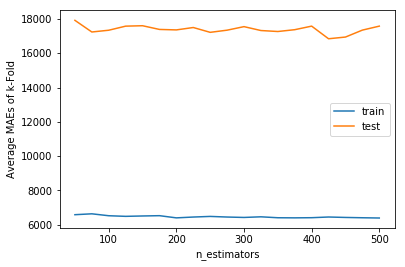

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# 畫出各參數表現的趨勢圖
fig, ax = plt.subplots()
ax.plot(train_mean_maes.keys(), train_mean_maes.values(), label='train')
ax.plot(test_mean_maes.keys(), test_mean_maes.values(), label='test')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Average MAEs of k-Fold')
ax.legend()

<a id="references"></a>

## References:

+ Dan Becker, *"Intermediate Machine Learning"*, Kaggle, 2019. [[link]](https://www.kaggle.com/learn/intermediate-machine-learning)